# Named Entity Recognition (NER)

## Purpose of the Project
* We will be doing Named Entity Recognition (NER) with XLM-RoBERTa model in this project.
* NER is harder than text classification.
* NER is a token classification task. In this analysis, each token will be classified. (a noun as "person", a company as "organization", or a place name as "place")

## Road Map of the Project
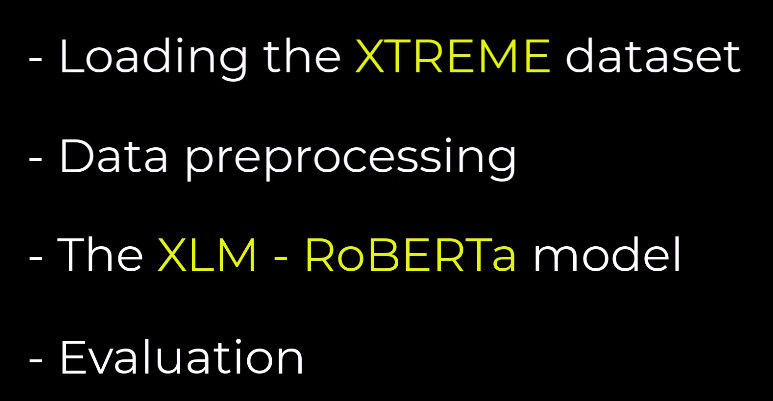

## About the Model
* Models written for one language do not work well when text in another language is entered.
* Multilingual transformers can be used for this.
* These models, like BERT, use masked language modeling.
* Some random words in the text are masked and these masked words are asked to be guessed.
* Multilingual transformers models are trained with this technique.
* These models are trained independently of the language. That's why it can be adapted to many languages.

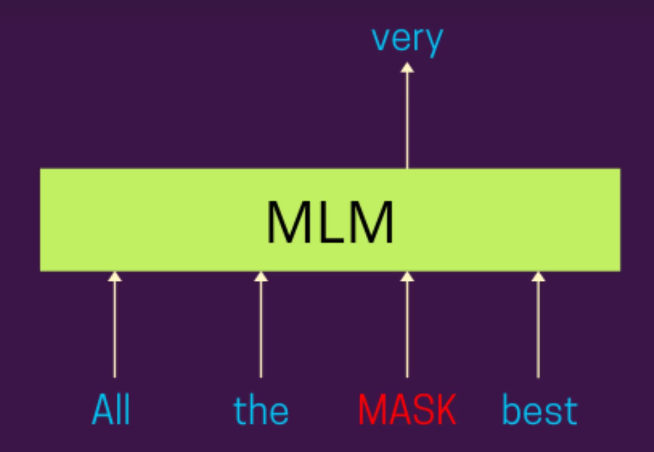

## Loading the Dataset for NER
* The 4 most used languages in Switzerland from the XTREME dataset will be used. (German, French, Italian, English)

In [1]:
!pip install -q datasets

In [2]:
from datasets import load_dataset

In [3]:
langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059] #frequency assignment according to the rate at which languages are spoken

In [4]:
from collections import defaultdict
# This library assigns a default value for a key not found in the dictionary.

In [5]:
from datasets import DatasetDict

panx_ch = defaultdict (DatasetDict)

In [6]:
# creating datasets
for lang, frac in zip(langs, fracs):
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    for split in ds:
        panx_ch[lang][split] = (
            ds[split].shuffle(seed=0).select(range(int(frac*ds[split].num_rows))))

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
# understanding dataset
import pandas as pd

In [9]:
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
            index = ["number of training examples"])

,de,fr,it,en
number of training examples,12580,4580,1680,1180


* We will train the model with German, then we'll use that model for other languages.

In [10]:
#first example of german
element = panx_ch["de"]["train"][0]

for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


* There are 3 columns. **Tokens**, **ner_tags** and **langs**.
* **ner_tags** column has numerical representation of tags such as place, person, organisation...

In [11]:
# see tags of numerical representations
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [13]:
# taking a closer look at the ner_tags column
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [14]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

In [16]:
# applying the function to the dataset with map() method
panx_de = panx_ch["de"].map(create_tag_names)

  0%|          | 0/12580 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

In [17]:
de_example = panx_de["train"][0]

pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
            ["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [18]:
# distribution of tags in the dataset
from collections import Counter

In [19]:
split2freqs = defaultdict(Counter)

In [20]:
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] +=1

In [21]:
pd.DataFrame.from_dict(split2freqs, orient = "index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071
